In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib

from IPython.display import clear_output, Image, display
from io import BytesIO

import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
tf.logging.set_verbosity(tf.logging.ERROR)

W0623 13:33:57.094846 4677387712 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
DIR = './hot_dog_not_hot_dog'
TRAIN_FRACTION = 0.8
RANDOM_SEED = 2018

def make_train_and_test_sets():
    """Split the data into train and test sets and get the label classes."""
    train_examples, test_examples = [], []
    shuffler = random.Random(RANDOM_SEED)
    is_root = True
    
    for (dirname, subdirs, filenames) in tf.gfile.Walk(DIR):
        # The root directory gives us the classes
        if is_root:
            subdirs = sorted(subdirs)
            classes = collections.OrderedDict(enumerate(subdirs))
            label_to_class = dict([(x, i) for i, x in enumerate(subdirs)])
            is_root = False
        
        # The sub directories give us the image files for training.
        else:
            filenames.sort()
            shuffler.shuffle(filenames)
            full_filenames = [os.path.join(dirname, f) for f in filenames]
            label = dirname.split('/')[-1]
            label_class = label_to_class[label]
      
            # An example is the image file and it's label class.
            examples = list(zip(full_filenames, [label_class] * len(filenames)))
            num_train = int(len(filenames) * TRAIN_FRACTION)
            train_examples.extend(examples[:num_train])
            test_examples.extend(examples[num_train:])

    shuffler.shuffle(train_examples)
    shuffler.shuffle(test_examples)
    return train_examples, test_examples, classes

In [3]:
# Download the images and split the images into train and test sets.
TRAIN_EXAMPLES, TEST_EXAMPLES, CLASSES = make_train_and_test_sets()
NUM_CLASSES = len(CLASSES)

print('The dataset has %d label classes: %s' % (NUM_CLASSES, list(CLASSES.values())))
print('There are %d training images' % len(TRAIN_EXAMPLES))
print('There are %d test images' % len(TEST_EXAMPLES))

The dataset has 2 label classes: ['hot_dog', 'not_hot_dog']
There are 798 training images
There are 200 test images


In [4]:
LEARNING_RATE = 0.01

image_module = hub.Module('https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/feature_vector/2')

# Preprocessing images into tensors with size expected by the image module.
encoded_images = tf.placeholder(tf.string, shape = [None])
image_size     = hub.get_expected_image_size(image_module)

def decode_and_resize_image(encoded):
    decoded = tf.image.decode_jpeg(encoded, channels = 3)
    decoded = tf.image.convert_image_dtype(decoded, tf.float32)
    return tf.image.resize_images(decoded, image_size)

batch_images = tf.map_fn(decode_and_resize_image, 
                         encoded_images, 
                         dtype=tf.float32)

features = image_module(batch_images)

def create_model(features):
    """Build a model for classification from extracted features."""
    layer1 = tf.layers.dense(inputs = features, units = 70, activation = tf.nn.relu)
    layer2 = tf.layers.dense(inputs = layer1, units = NUM_CLASSES, activation = None)
    return layer2

logits = create_model(features)
labels = tf.placeholder(tf.float32, [None, NUM_CLASSES])

cross_entropy      = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = labels)
cross_entropy_mean = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
train_op  = optimizer.minimize(loss = cross_entropy_mean)

probabilities = tf.nn.softmax(logits)

prediction         = tf.argmax(probabilities, 1)
correct_prediction = tf.equal(prediction, tf.argmax(labels, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

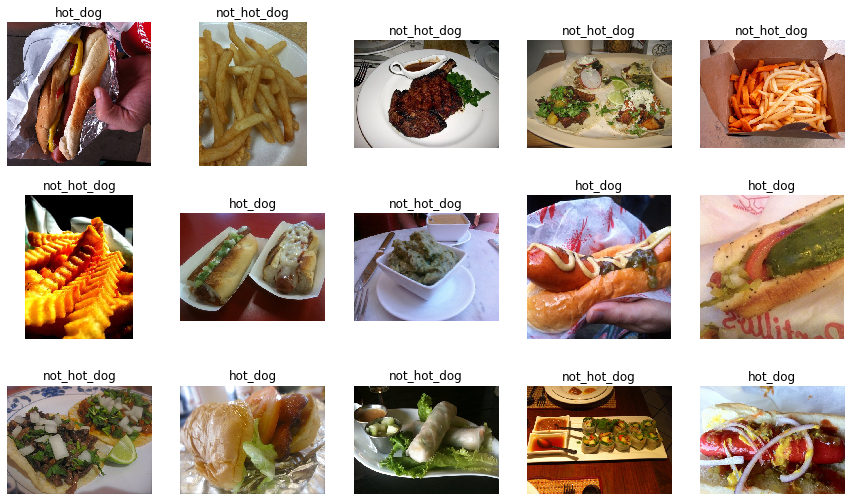

In [5]:
def get_label(example):
    """Get the label (number) for given example."""
    return example[1]

def get_class(example):
    """Get the class (string) of given example."""
    return CLASSES[get_label(example)]

def get_encoded_image(example):
    """Get the image data (encoded jpg) of given example."""
    image_path = example[0]
    return tf.gfile.FastGFile(image_path, 'rb').read()
  
def get_image(example):
    """Get image as np.array of pixels for given example."""
    return plt.imread(BytesIO(get_encoded_image(example)), format = 'jpg')

def display_images(images_and_classes, cols = 5):
    """Display given images and their labels in a grid."""
    rows = int(math.ceil(len(images_and_classes) / cols))
    fig = plt.figure()
    fig.set_size_inches(cols * 3, rows * 3)
    for i, (image, flower_class) in enumerate(images_and_classes):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(image)
        plt.title(flower_class)

NUM_IMAGES = 15
images_and_classes = []
for example in TRAIN_EXAMPLES[:NUM_IMAGES]:
    images_and_classes.append((get_image(example), get_class(example)))

display_images(images_and_classes)

In [6]:
NUM_TRAIN_STEPS  = 200
TRAIN_BATCH_SIZE = 10
EVAL_EVERY = 10

def get_batch(batch_size = None, test = False):
    """Get a random batch of examples."""
    examples = TEST_EXAMPLES if test else TRAIN_EXAMPLES
    if batch_size:
        batch_examples = random.sample(examples, batch_size)
    else:
        batch_examples = examples
    return batch_examples

def get_images_and_labels(batch_examples):
    images = [get_encoded_image(e) for e in batch_examples]
    one_hot_labels = [get_label_one_hot(e) for e in batch_examples]
    return images, one_hot_labels

def get_label_one_hot(example):
    """Get the one hot encoding vector for the example."""
    one_hot_vector = np.zeros(NUM_CLASSES)
    np.put(one_hot_vector, get_label(example), 1)
    return one_hot_vector

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(NUM_TRAIN_STEPS):
        # Get a random batch of training examples.
        train_batch = get_batch(batch_size = TRAIN_BATCH_SIZE)
        batch_images, batch_labels = get_images_and_labels(train_batch)
    
        # Run the train_op to train the model.
        feed_dict = {encoded_images: batch_images, labels: batch_labels}
        train_loss, _, train_accuracy = sess.run([cross_entropy_mean, train_op, accuracy],
                                                 feed_dict = feed_dict)
        is_final_step = (i == (NUM_TRAIN_STEPS - 1))
        if i % EVAL_EVERY == 0 or is_final_step:
            # Get a batch of test examples.
            test_batch = get_batch(batch_size = None, test = True)
            batch_images, batch_labels = get_images_and_labels(test_batch)
            
            # Evaluate how well our model performs on the test set.
            test_loss, test_accuracy, test_prediction, correct_predicate = sess.run(
            [cross_entropy_mean, accuracy, prediction, correct_prediction],
            feed_dict = {encoded_images: batch_images, labels: batch_labels})
            print('Test accuracy at step %s: %.2f%%' % (i, (test_accuracy * 100)))

Test accuracy at step 0: 53.50%
Test accuracy at step 10: 79.00%
Test accuracy at step 20: 74.50%
Test accuracy at step 30: 73.50%
Test accuracy at step 40: 77.50%
Test accuracy at step 50: 83.50%
Test accuracy at step 60: 82.00%
Test accuracy at step 70: 84.00%
Test accuracy at step 80: 83.00%
Test accuracy at step 90: 84.50%
Test accuracy at step 100: 85.50%
Test accuracy at step 110: 84.00%
Test accuracy at step 120: 84.50%
Test accuracy at step 130: 83.00%
Test accuracy at step 140: 88.00%
Test accuracy at step 150: 85.00%
Test accuracy at step 160: 88.00%
Test accuracy at step 170: 87.00%
Test accuracy at step 180: 89.00%
Test accuracy at step 190: 87.50%
Test accuracy at step 199: 89.00%


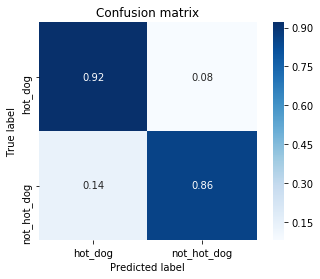

In [7]:
def show_confusion_matrix(test_labels, predictions):
    """Compute confusion matrix and normalize."""
    get_label   = np.argmax(test_labels, axis = 1)
    confusion   = sk_metrics.confusion_matrix(get_label, predictions)
    #Renormalize confusion
    confusion   = confusion.astype("float") / confusion.sum(axis = 1)
    axis_labels = list(CLASSES.values())
    ax = sns.heatmap(
            confusion, xticklabels = axis_labels, yticklabels = axis_labels,
            cmap = 'Blues', annot = True, fmt = '.2f', square = True)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

show_confusion_matrix(batch_labels, test_prediction)

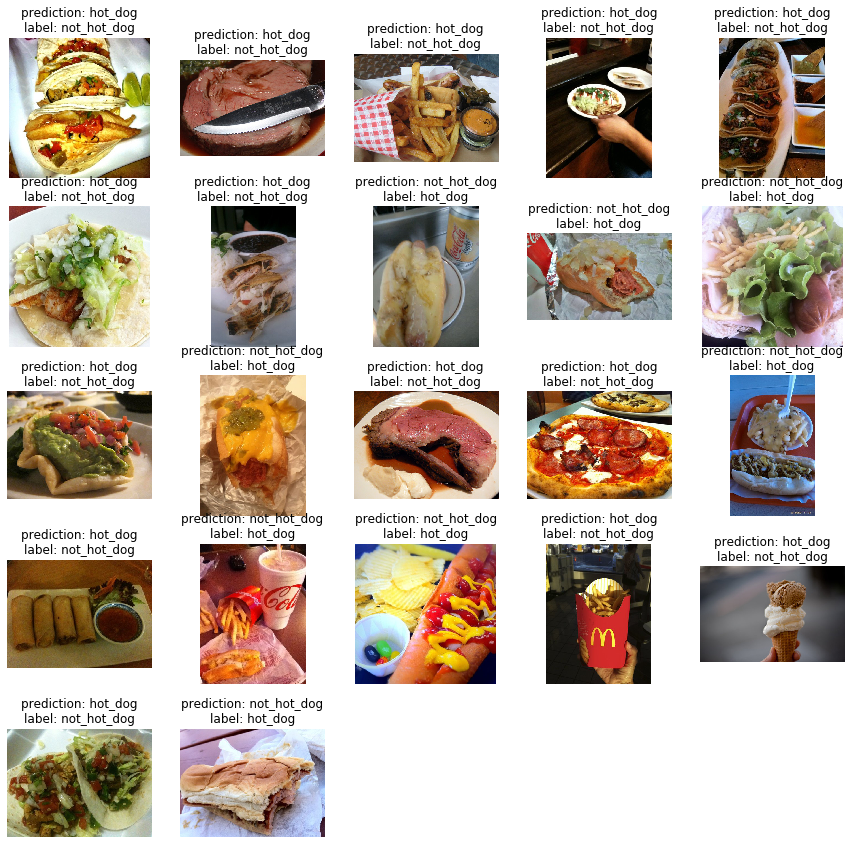

In [8]:
Zip = zip(test_batch, test_prediction, correct_predicate)
incorrect = []
for example, prediction, is_correct in Zip:
    if not is_correct: incorrect.append((example, CLASSES[prediction]))

incorrectly_labelled_images = []
label_template = "prediction: {0}\nlabel: {1}"
for (example, wrong_pred) in incorrect[:]:
    img = (
           get_image(example), 
           label_template.format(wrong_pred, get_class(example))
          )
    incorrectly_labelled_images.append(img)
        
display_images(incorrectly_labelled_images)